In [1]:
from benchmark import *
from utils import *

from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set this to read from a local path
experiment_uri = None

# None ⟹ fetch from S3
census_uri = None
#census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_version = "2023-12-15"

# By default:
# - `subset` if `experiment_uri` is a local path
# - `local` if `census_uri` is a local path
# - current (EC2 instance) region if `census_uri` is None (e.g. `us-east-1`, `us-west-2`)
name = None

collection_id = '283d65eb-dd53-496d-adb7-7570c7caa443'
# Slice datasets from `collection_id`
start = 2
end = 7

n_epochs = 1
batch_size = 1024
n_vars = 20_000
soma_chunk_size = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches
exclude_first_batch = True
progress_bar = True

# Plot configs
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
# Parameters
name = "us-east-1"
progress_bar = False


In [4]:
var_query = AxisQuery(coords=(slice(n_vars - 1),)) if n_vars else None

if experiment_uri:
    err(f"Loading experiment {experiment_uri}")
    with profile('open'):
        experiment = Experiment.open(experiment_uri)
    obs_query = None
    if name is None:
        scheme = urlparse(experiment_uri).scheme
        if is_local(experiment_uri):
            name = 'subset'
else:
    if not census_uri:
        census_uri = None
    
    if name is None:
        if census_uri and is_local(census_uri):
            name = 'local'
        else:
            name = get_region()
    
    err(f"Loading census ({name})")

    with profile('open_soma'):
        census = cellxgene_census.open_soma(uri=census_uri, census_version=census_version)
    
    datasets = get_datasets(census, collection_id, 'datasets')
    err(f"{len(datasets)} datasets: {datasets[:10]}")
    
    experiment = census["census_data"]["homo_sapiens"]
    ds = datasets[slice(start, end)]
    datasets_query = "dataset_id in " + str(ds)
    obs_query = AxisQuery(value_filter=datasets_query)

if not name:
    raise ValueError("`name` not set")

experiment

Loading census (us-east-1)


138 datasets: ['8e10f1c4-8e98-41e5-b65f-8cd89a887122', 'b165f033-9dec-468a-9248-802fc6902a74', 'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded', 'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd', 'fbf173f9-f809-4d84-9b65-ae205d35b523', 'fa554686-fc07-44dd-b2de-b726d82d26ec', 'f9034091-2e8f-4ac6-9874-e7b7eb566824', 'f8dda921-5fb4-4c94-a654-c6fc346bfd6d', 'f7d003d4-40d5-4de8-858c-a9a8b48fcc67', 'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181']


<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [5]:
%%time
with profile('get_exp_datapipe'):
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=obs_query,
        var_query=var_query,
        batch_size=batch_size,
        shuffle=True,
        soma_chunk_size=soma_chunk_size,
    )
    loader = experiment_dataloader(experiment_datapipe)
exp = Exp(experiment_datapipe, loader)
exp

CPU times: user 2.43 ms, sys: 3.5 ms, total: 5.93 ms
Wall time: 5.66 ms


Exp(datapipe=ExperimentDataPipe, loader=<torch.utils.data.dataloader.DataLoader object at 0x7f267af71410>)

In [6]:
%%time
exp.datapipe.shape[0]

CPU times: user 9.4 s, sys: 2.93 s, total: 12.3 s
Wall time: 10.5 s


133790

## Run benchmark

In [7]:
%%time
epochs = []
for epoch in range(n_epochs):
    with profile(f'benchmark-epoch{epoch}'):
        epoch = benchmark(
            exp,
            batch_size=batch_size,
            gc_freq=gc_freq,
            exclude_first_batch=exclude_first_batch,
            progress_bar=progress_bar,
        )
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

time per sample: 1130.71 μs
samples per sec: 884.40 samples/sec
CPU times: user 1min 55s, sys: 55.9 s, total: 2min 51s
Wall time: 2min 51s


In [8]:
tdb.stats

{'open_soma': [{'timers': {'Context.StorageManager.sm_load_group_metadata.sum': 0.07774,
    'Context.StorageManager.sm_load_group_metadata.avg': 0.07774,
    'Context.StorageManager.sm_load_group_from_uri.sum': 0.0809761,
    'Context.StorageManager.sm_load_group_from_uri.avg': 0.0809761,
    'Context.StorageManager.sm_load_group_details.sum': 0.0809811,
    'Context.StorageManager.sm_load_group_details.avg': 0.0809811,
    'Context.StorageManager.group_open_for_reads.sum': 0.080984,
    'Context.StorageManager.group_open_for_reads.avg': 0.080984},
   'counters': {'Context.StorageManager.read_unfiltered_byte_num': 373,
    'Context.StorageManager.read_group_size': 104,
    'Context.StorageManager.read_array_meta_size': 269,
    'Context.StorageManager.VFS.read_ops_num': 9,
    'Context.StorageManager.VFS.read_byte_num': 504,
    'Context.StorageManager.VFS.ls_num': 3,
    'Context.StorageManager.VFS.is_object_num': 1}}],
 'datasets': [{'timers': {'Context.StorageManager.sm_load_group_

In [9]:
tdbs.stats

{'open_soma': [],
 'datasets': [{'timers': {'Context.StorageManager.sm_load_fragment_metadata.sum': 0.297754,
    'Context.StorageManager.sm_load_fragment_metadata.avg': 0.148877,
    'Context.StorageManager.sm_load_filtered_fragment_uris.sum': 7.0624e-05,
    'Context.StorageManager.sm_load_filtered_fragment_uris.avg': 3.5312e-05,
    'Context.StorageManager.sm_load_array_schemas_and_fragment_metadata.sum': 0.374011,
    'Context.StorageManager.sm_load_array_schemas_and_fragment_metadata.avg': 0.187006,
    'Context.StorageManager.sm_load_array_schema_from_uri.sum': 0.0761343,
    'Context.StorageManager.sm_load_array_schema_from_uri.avg': 0.0380671,
    'Context.StorageManager.sm_load_array_metadata.sum': 0.0730066,
    'Context.StorageManager.sm_load_array_metadata.avg': 0.0730066,
    'Context.StorageManager.sm_load_all_array_schemas.sum': 0.0761619,
    'Context.StorageManager.sm_load_all_array_schemas.avg': 0.038081,
    'Context.StorageManager.array_open_read_load_schemas_and_fr

In [10]:
results_json_path = f'results/{name}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results/us-east-1.json


In [11]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [12]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
df = df.reset_index()
df

/tmp/ipykernel_11958/2254310219.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gc'] = df['gc'].fillna(nan)


,idx,batch
0,0,0.125494
1,1,1.864526
2,2,0.132608
3,3,0.126339
4,4,0.126785
...,...,...
125,125,0.100703
126,126,0.101287
127,127,0.100968
128,128,0.103448


In [13]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch
1,1,1.864526
8,8,8.702070
10,10,1.827670
17,17,11.932824
19,19,1.806496
26,26,8.949266
28,28,1.596068
36,36,6.661350
38,38,1.656847
45,45,12.198080


In [14]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-us-east-1.png


Returning IPython Image


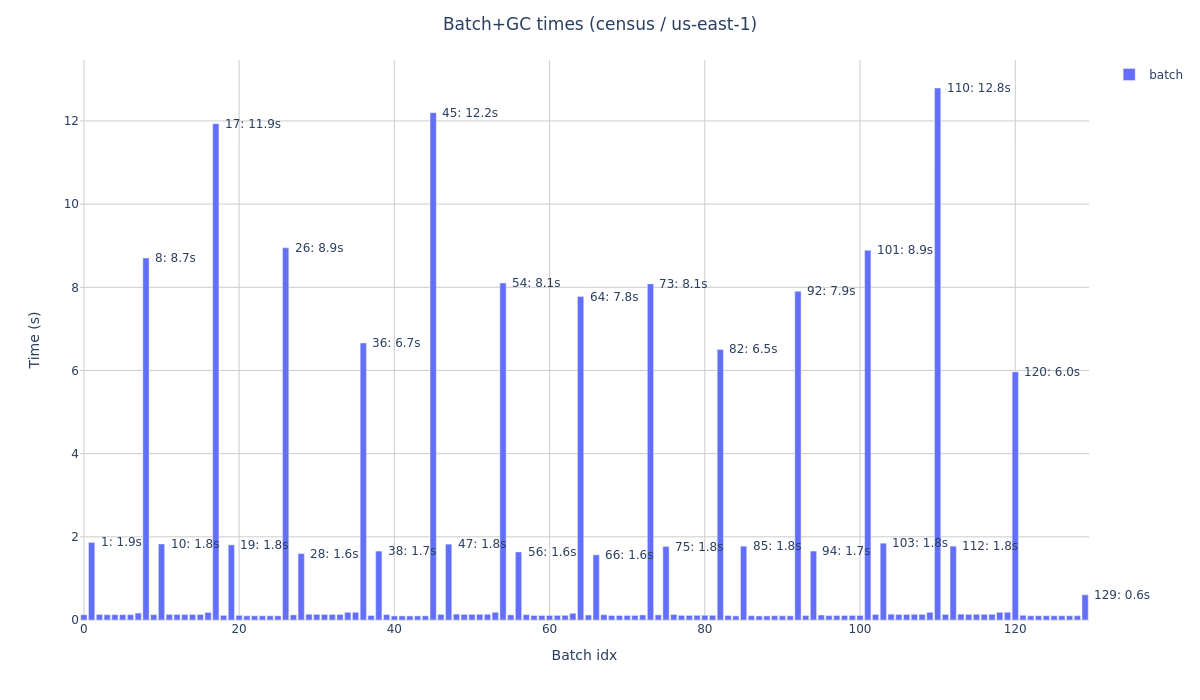

In [15]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {name})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{name}', fmt='png', save=['png'], w=width, h=height, dir='img',)